## Importing Libraries

In [1]:
# Importing necessary libraries for data processing, ML, and visualization
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
import random
import re
import shutil
import kagglehub
from copy import deepcopy
import warnings
import string
import itertools

from torch.utils.data import Dataset, random_split, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts

## Checkpoints

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a Folder in the root directory
!mkdir -p "/content/drive/My Drive/My Folder/checkpoints_shakespeare"

CHECKPOINT_DIR = '/content/drive/My Drive/My Folder/checkpoints_shakespeare'

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, hyperparameters, subfolder="", data_to_save=None):
    """Salva il checkpoint del modello e rimuove quello precedente."""
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    os.makedirs(subfolder_path, exist_ok=True)

    # File corrente e precedente
    filename = f"model_epoch_{epoch}_params_{hyperparameters}.pth"
    filepath = os.path.join(subfolder_path, filename)
    filename_json = f"model_epoch_{epoch}_params_{hyperparameters}.json"
    filepath_json = os.path.join(subfolder_path, filename_json)


    previous_filename = f"model_epoch_{epoch -1}_params_{hyperparameters}.pth"
    previous_filepath = os.path.join(subfolder_path, previous_filename)
    previous_filename_json = f"model_epoch_{epoch -1}_params_{hyperparameters}.json"
    previous_filepath_json = os.path.join(subfolder_path, previous_filename_json)

    # Rimuove il checkpoint precedente
    if epoch > 1 and os.path.exists(previous_filepath) and os.path.exists(previous_filepath_json):
        os.remove(previous_filepath)
        os.remove(previous_filepath_json)

    # Salva il nuovo checkpoint
    if optimizer is not None:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),  # Salvataggio dello stato dell'ottimizzatore
            'epoch': epoch
        }, filepath)
    else:
        torch.save({
            'model_state_dict': model.state_dict(),
            'epoch': epoch
        }, filepath)
    print(f"Checkpoint salvato: {filepath}")

    with open(filepath_json, 'w') as json_file:
      json.dump(data_to_save, json_file, indent=4)


def load_checkpoint(model, optimizer, hyperparameters, subfolder=""):
    """Carica l'ultimo checkpoint disponibile basato sugli iperparametri."""
    subfolder_path = os.path.join(CHECKPOINT_DIR, subfolder)
    if not os.path.exists(subfolder_path):
        print("No checkpoint found, Starting now...")
        return 1, None  # Le epoche iniziano da 1

    # Cerca i file con gli iperparametri specificati
    files = [f for f in os.listdir(subfolder_path) if f"params_{hyperparameters}" in f and f.endswith('.pth')]
    if files:
        # Trova il file con l'epoca più alta
        latest_file = max(files, key=lambda x: int(x.split('_')[2]))
        filepath = os.path.join(subfolder_path, latest_file)
        checkpoint = torch.load(filepath)

        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        # Trova e carica il file JSON associato
        json_filename = latest_file.replace('.pth', '.json')
        json_filepath = os.path.join(subfolder_path, json_filename)
        json_data = None
        if os.path.exists(json_filepath):
            with open(json_filepath, 'r') as json_file:
                json_data = json.load(json_file)
            print(f"JSON data loaded: {json_filepath}")
        else:
            print(f"No JSON file found for: {latest_file}")

        print(f"Checkpoint found: Resume epoch {checkpoint['epoch'] + 1}")
        return checkpoint['epoch'] + 1, json_data

    print("No checkpoint found, Starting now...")
    return 1, None  # Le epoche iniziano da 1



Mounted at /content/drive


## Text Processing

In [ ]:
TRAIN_FRACTION = 0.9

CHARACTER_RE = re.compile(r'^  ([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Matches character lines
CONT_RE = re.compile(r'^    (.*)')  # Matches continuation lines
COE_CHARACTER_RE = re.compile(r'^([a-zA-Z][a-zA-Z ]*)\. (.*)')  # Special regex for Comedy of Errors
COE_CONT_RE = re.compile(r'^(.*)')  # Continuation for Comedy of Errors

def parse_shakespeare_file(filepath):
    """
    Reads and splits Shakespeare's text into plays, characters, and their dialogues.
    Returns training and test datasets based on the specified fraction.
    """
    with open(filepath, "r") as f:
        content = f.read()
    plays, _ = _split_into_plays(content)  # Split the text into plays
    _, train_examples, test_examples = _get_train_test_by_character(
        plays, test_fraction=1 - TRAIN_FRACTION
    )
    print(f"Train examples: {len(train_examples)}")
    print(f"Test examples: {len(test_examples)}")
    return train_examples, test_examples

def _split_into_plays(shakespeare_full):
    """
    Splits the full Shakespeare text into individual plays and characters' dialogues.
    Handles special parsing for "The Comedy of Errors".
    """
    plays = []
    slines = shakespeare_full.splitlines(True)[1:]  # Skip the first line (title/header)
    current_character = None
    comedy_of_errors = False

    for i, line in enumerate(slines):
        # Detect play titles and initialize character dictionary
        if "by William Shakespeare" in line:
            current_character = None
            characters = defaultdict(list)
            title = slines[i - 2].strip() if slines[i - 2].strip() else slines[i - 3].strip()
            comedy_of_errors = title == "THE COMEDY OF ERRORS"
            plays.append((title, characters))
            continue

        # Match character lines or continuation lines
        match = _match_character_regex(line, comedy_of_errors)
        if match:
            character, snippet = match.group(1).upper(), match.group(2)
            if not (comedy_of_errors and character.startswith("ACT ")):
                characters[character].append(snippet)
                current_character = character
        elif current_character:
            match = _match_continuation_regex(line, comedy_of_errors)
            if match:
                characters[current_character].append(match.group(1))

    # Filter out plays with insufficient dialogue data
    return [play for play in plays if len(play[1]) > 1], []

def _match_character_regex(line, comedy_of_errors=False):
    """Matches character dialogues, with special handling for 'The Comedy of Errors'."""
    return COE_CHARACTER_RE.match(line) if comedy_of_errors else CHARACTER_RE.match(line)

def _match_continuation_regex(line, comedy_of_errors=False):
    """Matches continuation lines of dialogues."""
    return COE_CONT_RE.match(line) if comedy_of_errors else CONT_RE.match(line)

def _get_train_test_by_character(plays, test_fraction=0.2):
    """
    Splits dialogues by characters into training and testing datasets.
    Ensures each character has at least one example in the training set.
    """
    all_train_examples = defaultdict(list)
    all_test_examples = defaultdict(list)

    def add_examples(example_dict, example_tuple_list):
        """Adds examples to the respective dataset dictionary."""
        for play, character, sound_bite in example_tuple_list:
            example_dict[f"{play}_{character}".replace(" ", "_")].append(sound_bite)

    for play, characters in plays:
        for character, sound_bites in characters.items():
            examples = [(play, character, sound_bite) for sound_bite in sound_bites]
            if len(examples) <= 2:
                continue

            # Calculate the number of test samples
            num_test = max(1, int(len(examples) * test_fraction))
            num_test = min(num_test, len(examples) - 1)  # Ensure at least one training example

            # Split into train and test sets
            train_examples = examples[:-num_test]
            test_examples = examples[-num_test:]

            add_examples(all_train_examples, train_examples)
            add_examples(all_test_examples, test_examples)

    return {}, all_train_examples, all_test_examples


def letter_to_vec(c, n_vocab=128):
    """Converts a single character to a vector index based on the vocabulary size."""
    return ord(c) % n_vocab

def word_to_indices(word, n_vocab=128):
    """
    Converts a word or list of words into a list of indices.
    Each character is mapped to an index based on the vocabulary size.
    """
    if isinstance(word, list):  # If input is a list of words
        res = []
        for stringa in word:
            res.extend([ord(c) % n_vocab for c in stringa])  # Convert each word to indices
        return res
    else:  # If input is a single word
        return [ord(c) % n_vocab for c in word]

def process_x(raw_x_batch, seq_len, n_vocab):
    """
    Processes raw input data into padded sequences of indices.
    Ensures all sequences are of uniform length.
    """
    x_batch = [word_to_indices(word, n_vocab) for word in raw_x_batch]
    x_batch = [x[:seq_len] + [0] * (seq_len - len(x)) for x in x_batch]
    return torch.tensor(x_batch, dtype=torch.long)


def process_y(raw_y_batch, seq_len, n_vocab):
    """
    Processes raw target data into padded sequences of indices.
    Shifts the sequence by one character to the right.
    y[1:seq_len + 1] takes the input data, right shift of an
    element and uses the next element of the sequence to fill
    and at the end (with [0]) final padding (zeros) are (eventually)
    added to reach the desired sequence length.
    """
    y_batch = [word_to_indices(word, n_vocab) for word in raw_y_batch]
    y_batch = [y[1:seq_len + 1] + [0] * (seq_len - len(y[1:seq_len + 1])) for y in y_batch]  # Shifting and final padding
    return torch.tensor(y_batch, dtype=torch.long)

def create_batches(data, batch_size, seq_len, n_vocab):
    """
    Creates batches of input and target data from dialogues.
    Each batch contains sequences of uniform length.
    """
    x_batches = []
    y_batches = []
    dialogues = list(data.values())
    random.shuffle(dialogues)  # Shuffle to ensure randomness in batches

    batch = []
    for dialogue in dialogues:
        batch.append(dialogue)
        if len(batch) == batch_size:
            x_batch = process_x(batch, seq_len, n_vocab)
            y_batch = process_y(batch, seq_len, n_vocab)
            x_batches.append(x_batch)
            y_batches.append(y_batch)
            batch = []

    # Add the last batch if it's not full
    if batch:
        x_batch = process_x(batch, seq_len, n_vocab)
        y_batch = process_y(batch, seq_len, n_vocab)
        x_batches.append(x_batch)
        y_batches.append(y_batch)

    return x_batches, y_batches

## Shakespeare Dataset

In [29]:
ALL_LETTERS = "\n !\"&'(),-.0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]abcdefghijklmnopqrstuvwxyz}"
NUM_LETTERS = len(ALL_LETTERS)

def letter_to_index(letter):
    return torch.tensor(ALL_LETTERS.find(letter), dtype=torch.long )

def word_to_indices(word,  n_vocab=NUM_LETTERS):
    '''Returns a list of character indices for a given word'''
    indices = []
    for c in word:
        indices.append(ALL_LETTERS.find(c))
    return indices

def text_transform(text, max_length=80, vocab_size=NUM_LETTERS):
    '''Transform a string into a tensor with indices instead of one-hot encoding.'''
    # Tokenizzazione: converti ogni lettera in un indice
    indices = [ALL_LETTERS.find(char) for char in text]

    # Padding o Troncamento per lunghezza fissa
    if len(indices) < max_length:
        indices += [0] * (max_length - len(indices))  # Pad con zeri (carattere vuoto)
    else:
        indices = indices[:max_length]  # Troncamento se il testo è più lungo

    # Restituisci il tensore di indici
    return torch.tensor(indices, dtype=torch.long)

class CentralizedShakespeareDataset(Dataset):
    def __init__(self, root, split, preprocess_params=None, transform=None):
        """
        Args:
            root (str): Path to the dataset directory.
            split (str): Dataset split, either 'train' or 'test'.
            preprocess_params (dict, optional): Parameters for running preprocess.sh script. Keys include:
                - sharding (str): 'iid' or 'niid' for data partitioning.
                - iu (float): Fraction of users if i.i.d. sampling.
                - sf (float): Fraction of data to sample.
                - k (int): Minimum number of samples per user.
                - t (str): 'user' or 'sample' for train-test partition.
                - tf (float): Fraction of data in training set.
                - raw (bool): Include raw text data.
                - smplseed (int): Seed for sampling.
                - spltseed (int): Seed for splitting.
        """
        self.root = root
        self.split = split
        self.preprocess_params = preprocess_params or {}


        # Ensure the working directory is set to the dataset folder
        os.chdir(self.root)

        # Run preprocessing script if needed
        self._preprocess_data()

        # Load the dataset
        self.data = self._load_data()

        # Create a label map to convert string targets to integers
        #self.label_map = self.create_label_map()

    def _preprocess_data(self):
        """Runs preprocess.sh with the given parameters."""
        cmd = "bash preprocess.sh"

        if 'sharding' in self.preprocess_params:
            cmd += f" -s {self.preprocess_params['sharding']}"
        if 'iu' in self.preprocess_params:
            cmd += f" --iu {self.preprocess_params['iu']}"
        if 'sf' in self.preprocess_params:
            cmd += f" --sf {self.preprocess_params['sf']}"
        if 'k' in self.preprocess_params:
            cmd += f" -k {self.preprocess_params['k']}"
        if 't' in self.preprocess_params:
            cmd += f" -t {self.preprocess_params['t']}"
        if 'tf' in self.preprocess_params:
            cmd += f" --tf {self.preprocess_params['tf']}"
        if 'raw' in self.preprocess_params and self.preprocess_params['raw']:
            cmd += f" --raw"
        if 'smplseed' in self.preprocess_params:
            cmd += f" --smplseed {self.preprocess_params['smplseed']}"
        if 'spltseed' in self.preprocess_params:
            cmd += f" --spltseed {self.preprocess_params['spltseed']}"

        print(f"Running command: {cmd}")
        os.system(cmd)
        os.chdir(self.root)

    def _load_data(self):
        """Loads data from the JSON file in the train or test folder, assuming only one file per folder."""
        folder_path = os.path.join(self.root, 'data', self.split)
        print(f"Absolute folder path: {os.path.abspath(folder_path)}")
        json_files = [f for f in os.listdir(folder_path) if f.endswith(".json")]

        if len(json_files) != 1:
            raise ValueError(f"Expected exactly one JSON file in {folder_path}, but found {len(json_files)} files.")

        file_path = os.path.join(folder_path, json_files[0])

        # Carica i dati dal file JSON
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Converti la struttura JSON in un DataFrame di pandas
        records = []
        for user, user_data in data['user_data'].items():
            for x, y in zip(user_data['x'], user_data['y']):
                records.append({
                    'client_id': int(user),
                    'x': x,  # Cambiato input in x
                    'y': y   # Cambiato target in y
                })

        return pd.DataFrame(records)

    def create_label_map(self):
        """Creates a mapping from string labels to integer labels."""
        unique_labels = sorted(self.data['y'].unique())
        print(f"Unique labels: {unique_labels}")  # Debug
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        return label_map

    def get_dataframe(self):
        """Returns the dataset as a pandas DataFrame."""
        return self.data

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        sample = {
            'x': self.data.iloc[idx]['x'],
            'y': self.data.iloc[idx]['y']
        }

        sample['x'] = text_transform(sample['x'])  # x is a tensor of one-hot vectors
        sample['y'] = text_transform(sample['y'])  # y is a tensor of one-hot vectors

        return sample['x'], sample['y']


## Shakespeare Model Architecture

In [30]:
class ShakespeareLSTM(nn.Module):
    def __init__(self, vocab_size=80, embed_dim=8, lstm_hidden_dim=256, seq_len=80, batch_size=32):
        super(ShakespeareLSTM, self).__init__()

        self.seq_len = seq_len
        self.batch_size = batch_size
        self.lstm_hidden_dim = lstm_hidden_dim
        self.vocab_size = vocab_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_size=embed_dim, hidden_size=lstm_hidden_dim, batch_first=True)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(input_size=lstm_hidden_dim, hidden_size=lstm_hidden_dim, batch_first=True)

        # Dense output layer
        self.dense = nn.Linear(lstm_hidden_dim, vocab_size)

    def init_hidden(self, batch_size):
        """
        Inizializza lo stato nascosto e la cella della LSTM come tensori di zeri.
        """
        h0 = torch.zeros(2, batch_size, self.lstm_hidden_dim).to(self.device)
        c0 = torch.zeros(2, batch_size, self.lstm_hidden_dim).to(self.device)
        return (h0, c0)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_len)
        batch_size = x.size(0)
        x = self.embedding(x)  # (batch_size, seq_len, embed_dim)

        x, hidden = self.lstm1(x, hidden)  # (batch_size, seq_len, lstm_hidden_dim)

        x, hidden = self.lstm2(x, hidden)  # (batch_size, seq_len, lstm_hidden_dim)

        x = self.dense(x)  # (batch_size, seq_len, vocab_size)

        return x, hidden

## Centralized training functions

In [31]:
def train_model(model, train_loader, validation_loader, test_loader, optimizer, scheduler, criterion, epochs, hyperparameters):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses, validation_losses, validation_accuracies, test_losses, test_accuracies = [], [], [], [], []

    # Load checkpoint if exists
    start_epoch, json_data = load_checkpoint(model, optimizer, hyperparameters)
    if json_data is not None:
        validation_losses = json_data.get('validation_losses', [])
        validation_accuracies = json_data.get('validation_accuracies', [])
        train_losses = json_data.get('train_losses', [])
        test_losses = json_data.get('test_losses', [])
        test_accuracies = json_data.get('test_accuracies', [])

    if start_epoch >= epochs:
        print(f"Checkpoint found, configuration already completed. Evaluating only on validation set.")
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        return train_losses, validation_losses, validation_accuracies

    # Main training loop
    for epoch in range(start_epoch, epochs + 1):
        model.train()
        epoch_loss = 0
        total_batches = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            try:
                # Ensure inputs and targets are within valid range
                if inputs.max() >= model.vocab_size or inputs.min() < 0:
                    print(f"Invalid input indices found. Max: {inputs.max()}, Min: {inputs.min()}")
                    continue

                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs, _ = model(inputs)  # Ignora gli hidden states


                # Reshape for loss calculation
                batch_size, seq_len, vocab_size = outputs.shape
                outputs = outputs.view(-1, vocab_size)
                targets = targets.view(-1)

                # Create mask for non-padding tokens
                non_pad_mask = targets != 0

                # Only compute loss on non-padding tokens
                valid_outputs = outputs[non_pad_mask]
                valid_targets = targets[non_pad_mask]

                if len(valid_targets) > 0:  # Only compute loss if we have valid tokens
                    loss = criterion(valid_outputs, valid_targets)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    total_batches += 1

            except RuntimeError as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue

        if total_batches > 0:
            epoch_loss = epoch_loss / total_batches

        scheduler.step()

        # Validation
        validation_loss, validation_accuracy = evaluate_model(model, validation_loader, criterion, device)
        train_losses.append(epoch_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Test
        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch}/{epochs}, Train Loss: {epoch_loss:.4f}, "
              f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.4f}"
              f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

        # Save checkpoint
        save_checkpoint(
            model, optimizer, epoch, hyperparameters, "Centralized/",
            data_to_save={
                'validation_losses': validation_losses,
                'validation_accuracies': validation_accuracies,
                'train_losses': train_losses,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies
            }
        )

    # Final evaluation on test set
    test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, validation_losses, validation_accuracies

def evaluate_model(model, test_loader, criterion, device):
    total_loss = 0
    correct = 0
    total = 0
    total_batches = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            try:
                if inputs.max() >= model.vocab_size or inputs.min() < 0:
                    continue

                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs,_ = model(inputs)
                batch_size, seq_len, vocab_size = outputs.shape
                outputs = outputs.view(-1, vocab_size)
                targets = targets.view(-1)

                # Create mask for non-padding tokens
                non_pad_mask = targets != 0
                valid_outputs = outputs[non_pad_mask]
                valid_targets = targets[non_pad_mask]

                if len(valid_targets) > 0:
                    loss = criterion(valid_outputs, valid_targets)
                    total_loss += loss.item()
                    total_batches += 1

                    _, predicted = valid_outputs.max(1)
                    total += valid_targets.size(0)
                    correct += (predicted == valid_targets).sum().item()

            except RuntimeError as e:
                print(f"Error during evaluation: {str(e)}")
                continue

    avg_loss = total_loss / total_batches if total_batches > 0 else float('inf')
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy

## Centralized training

In [7]:
# Always run before creating new datasets

if os.path.exists("/content/leaf/"):
  # Use shutil.rmtree to remove the folder and its contents
  shutil.rmtree("/content/leaf")
  print(f"Successfully deleted folder leaf")

os.chdir("/content/")
!git clone https://github.com/maxfra01/leaf.git

# -----------------------------------------

preprocess_params = {
        'sharding': 'iid',
        'sf': 0.06,
        'iu': 0.089,
        't': 'sample',
        'tf': 0.8,
    } # Get the full-size dataset

train_dataset_big = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="train", preprocess_params=preprocess_params)
test_dataset = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="test", preprocess_params=preprocess_params)
print(f"Train dataset: {len(train_dataset_big)} samples\n"
      f"Test dataset: {len(test_dataset)} samples")

Successfully deleted folder leaf
Cloning into 'leaf'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 772 (delta 0), reused 0 (delta 0), pack-reused 766 (from 1)
Receiving objects: 100% (772/772), 6.78 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.06 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/train
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.06 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/test
Train dataset: 202800 samples
Test dataset: 42869 samples


No checkpoint found, Starting now...
Epoch 1/20, Train Loss: 2.6690, Validation Loss: 2.4851, Validation Accuracy: 0.3030
Test Loss: 2.4935, Test Accuracy: 0.2968
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_1_params_BS40_LR0.1_WD0.001_M0.9.pth
Epoch 2/20, Train Loss: 2.3839, Validation Loss: 2.3386, Validation Accuracy: 0.3506
Test Loss: 2.3445, Test Accuracy: 0.3520
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_2_params_BS40_LR0.1_WD0.001_M0.9.pth
Epoch 3/20, Train Loss: 2.3038, Validation Loss: 2.2820, Validation Accuracy: 0.3551
Test Loss: 2.2947, Test Accuracy: 0.3582
Checkpoint salvato: /content/drive/My Drive/My Folder/checkpoints_shakespeare/Centralized/model_epoch_3_params_BS40_LR0.1_WD0.001_M0.9.pth
Epoch 4/20, Train Loss: 2.2544, Validation Loss: 2.2199, Validation Accuracy: 0.3787
Test Loss: 2.2319, Test Accuracy: 0.3702
Checkpoint salvato: /content/drive/My Driv

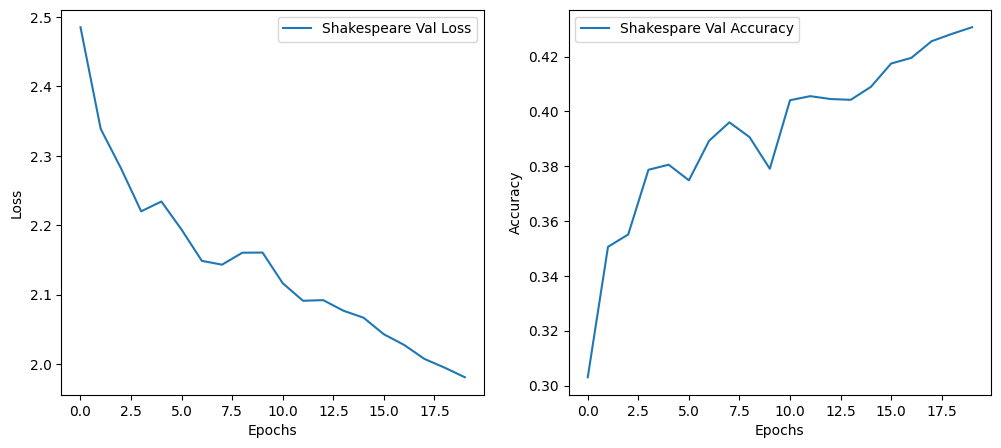

In [ ]:
# Hyperparameters
BATCH_SIZE = 40
LEARNING_RATE = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY=1e-3
EPOCHS = 20

hyperparameters = f"BS{BATCH_SIZE}_LR{LEARNING_RATE}_WD{WEIGHT_DECAY}_M{MOMENTUM}"

model_shakespeare = ShakespeareLSTM()

indexes = range(0, len(train_dataset_big))
splitting = train_test_split(indexes, train_size = 0.8, random_state = 42, shuffle = True)
train_indexes = splitting[0]
val_indexes = splitting[1]

train_dataset = Subset(train_dataset_big, train_indexes)
val_dataset = Subset(train_dataset_big, val_indexes)


# Create Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2)


optimizer = optim.SGD(
    model_shakespeare.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss()

# Train the model
train_losses, val_losses, val_accuracies = train_model(
    model=model_shakespeare,
    train_loader=train_dataloader,
    validation_loader= val_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=EPOCHS,
    hyperparameters=hyperparameters
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(val_losses, label='Shakespeare Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Shakespare Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


## Federated Learning classes

In [32]:
class Client:

  def __init__(self, model, client_id, data, optimizer_params):
    self.client_id = client_id
    self.data = data
    self.model = model
    self.optimizer_params = optimizer_params


  def train(self, global_weights, local_steps, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)
    self.model.load_state_dict(global_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        self.model.parameters(),
        lr=self.optimizer_params['lr'],
        momentum=self.optimizer_params['momentum'],
        weight_decay=self.optimizer_params['weight_decay']
        )
    trainloader = DataLoader(self.data, batch_size=batch_size, shuffle=True,  pin_memory=True)

    steps = 0
    while steps < local_steps:
      for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, _ = self.model(inputs)  # Ignora gli hidden states

        batch_size, seq_len, vocab_size = outputs.shape
        outputs = outputs.view(-1, vocab_size)
        targets = targets.view(-1)

        non_pad_mask = targets != 0

        # Only compute loss on non-padding tokens
        valid_outputs = outputs[non_pad_mask]
        valid_targets = targets[non_pad_mask]

        if len(valid_targets) > 0:  # Only compute loss if we have valid tokens
          loss = criterion(valid_outputs, valid_targets)
          loss.backward()
          optimizer.step()
          steps += 1
        if steps >= local_steps:
          break

    return self.model.state_dict()



class Server:

  def __init__(self, model, clients, test_data, val_data):
    self.model = model
    self.clients = clients
    self.val_data = val_data
    self.test_data = test_data
    self.round_losses = []
    self.round_accuracies = []
    self.selected_clients_per_round = [] #clint selezionati per skewness
    self.test_losses = []
    self.test_accuracies = []

  def federated_averaging(self, local_steps, batch_size, num_rounds, fraction_fit, hyperparameters = None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model.to(device)

    # Carica il checkpoint se esiste
    data_to_load = None
    start_epoch, data_to_load = load_checkpoint(self.model,optimizer=None,hyperparameters=hyperparameters, subfolder="Federated_Uniform/")

    if data_to_load is not None:
      self.round_losses = data_to_load['round_losses']
      self.round_accuracies = data_to_load['round_accuracies']
      self.selected_clients_per_round = data_to_load['selected_clients_per_round']
      self.test_losses = data_to_load['test_losses']
      self.test_accuracies = data_to_load['test_accuracies']


    for round in range(start_epoch, num_rounds+1):

      selected_clients = np.random.choice(self.clients, size=max(1, int(fraction_fit*len(self.clients))), replace=False)

      self.selected_clients_per_round.append([client.client_id for client in selected_clients])


      global_weights = self.model.state_dict()

      # Simulating parallel clients training
      client_weights = {}
      for client in selected_clients:
        client_weights[client.client_id] = client.train(global_weights, local_steps, batch_size)

      new_global_weights = {key: torch.zeros_like(value).type(torch.float32) for key, value in global_weights.items()}

      total_data_size = sum([len(client.data) for client in selected_clients])
      for client in selected_clients:
        scaling_factor = len(client.data) / total_data_size
        for key in new_global_weights.keys():
          new_global_weights[key] += scaling_factor * client_weights[client.client_id][key]

      # Update global model weights
      self.model.load_state_dict(new_global_weights)

      # Evaluate global model every 10 rounds
      if round % 10 == 0:
        loss, accuracy = evaluate_model(self.model, DataLoader(self.val_data, batch_size=batch_size, shuffle=False, pin_memory=True), nn.CrossEntropyLoss(), device)
        loss_test, accuracy_test = evaluate_model(self.model, DataLoader(self.test_data, batch_size=batch_size, shuffle=False, pin_memory=True), nn.CrossEntropyLoss(), device)

        self.round_losses.append(loss)
        self.round_accuracies.append(accuracy)
        self.test_losses.append(loss_test)
        self.test_accuracies.append(accuracy_test)
        print(f"Round {round}/{num_rounds} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

        data_to_save = {
          'round_losses': self.round_losses,
          'round_accuracies': self.round_accuracies,
          'test_losses': self.test_losses,
          'test_accuracies': self.test_accuracies,
          'selected_clients_per_round': [[client for client in round_clients] for round_clients in self.selected_clients_per_round]  # Serializziamo solo i client_id
      }

        save_checkpoint(self.model, None, round , hyperparameters, "Federated_Uniform/", data_to_save)

    #print("Evaluation on test set...")
    #loss, accuracy = evaluate_model(self.model, DataLoader(self.test_data, batch_size=batch_size, shuffle=False, pin_memory=True), nn.CrossEntropyLoss(), device)
    #print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

     # Plot dei risultati
    plt.figure(figsize=(16, 10))

        # Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(range(0, num_rounds, 10), self.round_losses, label='Validation Loss')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.title('Validation Loss per Round')
    plt.legend()

        # Validation Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(range(0, num_rounds, 10), self.round_accuracies, label='Validation Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy per Round')
    plt.legend()

    # Test Loss
    plt.subplot(2, 2, 3)
    plt.plot(range(0, num_rounds, 10), self.test_losses, label='Test Loss', color='orange')
    plt.xlabel('Round')
    plt.ylabel('Loss')
    plt.title('Test Loss per Round')
    plt.legend()

    # Test Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(range(0, num_rounds, 10), self.test_accuracies, label='Test Accuracy', color='green')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy per Round')
    plt.legend()

    plt.tight_layout()
    file_name = f"Shakespeare_fedavg_uniform_{hyperparameters}.jpg"
    plt.savefig(file_name)
    plt.show()


In [33]:
# Always run before creating new datasets

if os.path.exists("/content/leaf/"):
  # Use shutil.rmtree to remove the folder and its contents
  shutil.rmtree("/content/leaf")
  print(f"Successfully deleted folder leaf")

os.chdir("/content/")
!git clone https://github.com/maxfra01/leaf.git

# -----------------------------------------

preprocess_params = {
        'sharding': 'iid',
        'sf': 0.06,
        'iu': 0.089,
        't': 'sample',
        'tf': 0.8,
    } # Get the full-size dataset

train_dataset_big = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="train", preprocess_params=preprocess_params)
test_dataset = CentralizedShakespeareDataset(root="/content/leaf/data/shakespeare", split="test", preprocess_params=preprocess_params)
print(f"Train dataset: {len(train_dataset_big)} samples\n"
      f"Test dataset: {len(test_dataset)} samples")

Successfully deleted folder leaf
Cloning into 'leaf'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 772 (delta 0), reused 0 (delta 0), pack-reused 766 (from 1)
Receiving objects: 100% (772/772), 6.78 MiB | 6.10 MiB/s, done.
Resolving deltas: 100% (363/363), done.
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.06 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/train
Running command: bash preprocess.sh -s iid --iu 0.089 --sf 0.06 -t sample --tf 0.8
Absolute folder path: /content/leaf/data/shakespeare/data/test
Train dataset: 202800 samples
Test dataset: 42869 samples


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
      client_id                                                  x  y
0             0  ur'd miles, And many miles, the Princess bids ...   
1             0   My wife's a hobby-horse, deserves a name As r...   
2             0  em both; th' other's a jeweller. You are rapt,...  n
3             0   shall be so my care To have you royally appoi...   
4             0  o come, woe, and unrest; Thy friends are fled,...  y
...         ...                                                ... ..
2023          0   weakness! If they had swallow'd poison 'twoul...   
2024          0  Love my wife! What name, sir? [Aside] I will b...   
2025          0  ill we dine. This woman that I mean, My wife-b.

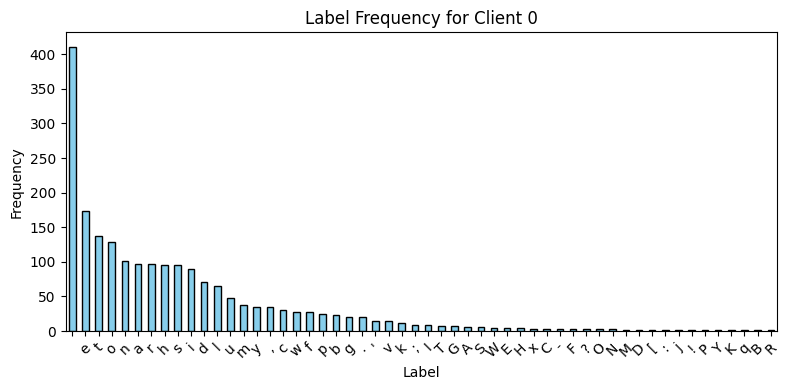

In [28]:
clients = train_dataset_big.data['client_id'].unique()
print(clients)
for client_id in clients:
  if client_id != 0:
    break
  client_data = train_dataset_big.data[train_dataset_big.data['client_id'] == client_id]
  print(client_data)
  label_counts = client_data['y'].value_counts()

  plt.figure(figsize=(8, 4))
  label_counts.plot(kind='bar', color='skyblue', edgecolor='black')
  plt.title(f"Label Frequency for Client {client_id}")
  plt.xlabel("Label")
  plt.ylabel("Frequency")
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.savefig(f"{CHECKPOINT_DIR}/plots/{preprocess_params['sharding']}_class_frequency_client_{client_id}.jpg")
  plt.show()


In [ ]:
BATCH_SIZE = 4
LR = 0.1
WEIGHT_DECAY = 1e-3
MOMENTUM = 0.9

ROUNDS = 200
C = 0.1
K=100
LOCAL_STEPS = 4

optimizer_params = {
      "lr": LR,
      "momentum": MOMENTUM,
      "weight_decay": WEIGHT_DECAY
  }

hyperparameters = hyperparameters = f"BS{BATCH_SIZE}_LR{LR}_M{MOMENTUM}_WD{WEIGHT_DECAY}_J{LOCAL_STEPS}_C{C}"

model_shakespeare = ShakespeareLSTM()

train_indices, validation_indices = train_test_split(
    range(len(train_dataset_big)), test_size=0.2, random_state=42
)

train_dataset = Subset(train_dataset_big, train_indices)
validation_dataset = Subset(train_dataset_big, validation_indices)

original_to_subset = {original_idx: subset_idx for subset_idx, original_idx in enumerate(train_indices)}

clients = []
for i in range(K):
    client_original_indices = train_dataset_big.data[
        train_dataset_big.data["client_id"] == i
    ].index

    # Converte gli indici originali in indici del subset
    client_subset_indices = [original_to_subset[idx] for idx in client_original_indices if idx in original_to_subset]

    # Crea il subset per il client
    client_data = Subset(train_dataset, client_subset_indices)
    clients.append(Client(model_shakespeare, i, client_data, optimizer_params))



server_uniform = Server(model_shakespeare, clients, test_dataset, validation_dataset)
server_uniform.federated_averaging(local_steps=LOCAL_STEPS, batch_size=BATCH_SIZE, num_rounds=ROUNDS, fraction_fit=C,hyperparameters=hyperparameters)